
## Copyright

Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérjük
az alábbi szerzőt értesíteni.

2019 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu),
Gyires-Tóth Bálint, Zainkó Csaba


Original GAN example from:

Links:

[Keras-GAN] https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

[CGAN] https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/





In [0]:
# original example from https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

In [0]:
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

# a '02_GAN_mnist' példából indulunk ki, és alakítjuk át feltételes GAN-ná

# újdonságok a GAN-hoz képest:
from keras.layers import multiply, Embedding
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [0]:
class Conditional_GAN_image():

  # diszkriminátor hálózat: kép + hozzá tartozó címke alapján bináris döntés,
  # hogy valódi vagy hamis
  # (az eleje, a model.summary()-ig ugyanaz, mint az előző GAN példa)

  def build_discriminator(self):

    model = Sequential()

    model.add(Dense(512, input_dim=np.prod(self.img_shape)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=self.img_shape)
    
    # újdonság a CGAN-ban a GAN-hoz képest
    # itt adjuk hozzá a címkét:
    # 0..9-ből Embedding
    label = Input(shape=(1,), dtype='int32')

    label_embedding = Flatten()(Embedding(self.num_classes, np.prod(self.img_shape))(label))
    flat_img = Flatten()(img)

    # összeszorozzuk a képet és az embedding eredményét
    model_input = multiply([flat_img, label_embedding])

    validity = model(model_input)

    return Model([img, label], validity)


  # generátor hálózat: zajból + címkéből kép generálás,
  # azaz adott osztályú képet generálunk
  # (az eleje, a model.summary()-ig ugyanaz, mint az előző GAN példa)
  def build_generator(self):

    model = Sequential()

    model.add(Dense(256, input_dim=self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    model.summary()

    noise = Input(shape=(self.latent_dim,))

    # újdonság a CGAN-ban a GAN-hoz képest
    # itt adjuk hozzá a címkét:
    # 0..9-ből Embedding
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))

    # összeszorozzuk a zajt és az embedding eredményét
    model_input = multiply([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    
    # látens dimenzió: belső reprezentáció mérete
    self.latent_dim = 100

    # újdonság a CGAN-ban a GAN-hoz képest: az osztályok száma
    self.num_classes = 10

    optimizer = Adam(0.0002, 0.5)

    # diszkriminátor build és compile
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss=['binary_crossentropy'],
        optimizer=optimizer,
        metrics=['accuracy'])

    # generátor build
    self.generator = self.build_generator()

    # újdonság a CGAN-ban a GAN-hoz képest
    # generátor: zaj + címke bemenetből képet készít
    # újdonság a CGAN-ban a GAN-hoz képest: a címke bemenet
    noise = Input(shape=(self.latent_dim,))
    label = Input(shape=(1,))
    img = self.generator([noise, label])

    # együttes modell - itt csak a generátort tanítjuk
    self.discriminator.trainable = False

    # diszkriminátor: generált képekről + címkéről eldönti, hogy valódiak-e
    # újdonság a CGAN-ban a GAN-hoz képest: a címke bemenet
    valid = self.discriminator([img, label])

    # együttes modell
    # cél: a generátor megtanulja, hogyan csaphatja be a diszkriminátort
    # újdonság a CGAN-ban a GAN-hoz képest: a címke bemenet
    self.combined = Model([noise, label], valid)
    self.combined.compile(loss=['binary_crossentropy'],
        optimizer=optimizer)

In [0]:
# tanítás paraméterek
steps = 30000
batch_size = 128
sample_interval = 50

In [0]:
# az első summary a diszkriminátor hálózat alja,
#  (kép + címke -> bináris döntés)
# a második summary a generátor hálózat aljára vonatkozik
#  (mintavételezett zaj + címke -> kép)

cgan = Conditional_GAN_image()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "sequen

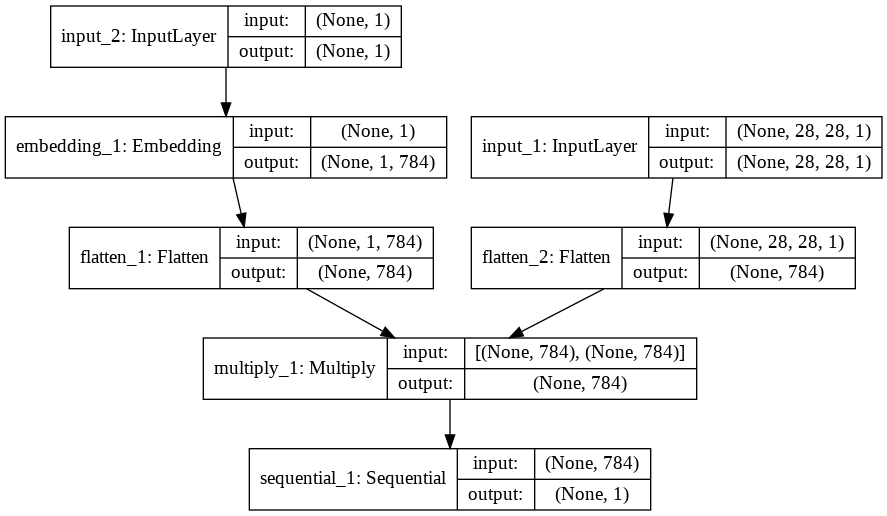

In [0]:
# rajzoljuk ki a diszkriminátor bemenetét: címkéből embedding + kép
plot_model(cgan.discriminator, show_shapes=True, show_layer_names=True)

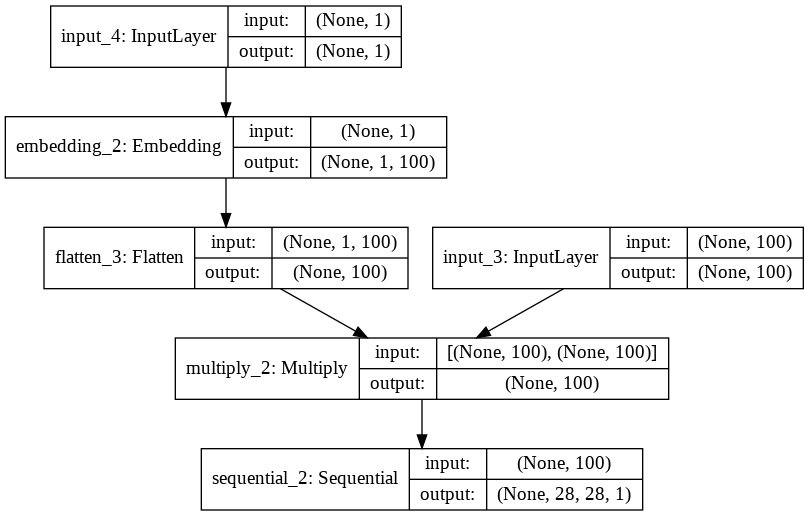

In [0]:
# rajzoljuk ki a generátor bemenetét: címkéből embedding + zaj
plot_model(cgan.generator, show_shapes=True, show_layer_names=True)

In [0]:
# adatok betöltése
# újdonság a CGAN-ban a GAN-hoz képest: fashion_mnist (ruhadarabok, 10 osztályba sorolva)
from keras.datasets import fashion_mnist
(x_train, y_train), (_, _) = fashion_mnist.load_data()

# skálázás -1 és 1 közé
x_train = x_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis = 3) # legyen channel dim is

# újdonság a CGAN-ban a GAN-hoz képest: a címkéket is használjuk
y_train = y_train.reshape(-1, 1)

# diszkriminátor kimenetek
valid = np.ones((batch_size, 1)) # D(x)    = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0

4423680/4422102 [==============================] - 2s 0us/step


In [0]:
# generált képek kirajzolása

from IPython import display

def plot_images(gan, step):
  r, c = 2,5
  noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
  
  # újdonság a CGAN-ban a GAN-hoz képest: a címke bemenet
  sampled_labels = np.arange(0, 10).reshape(-1, 1)
  gen_imgs = gan.generator.predict([noise, sampled_labels])
  
  # rescale to 0-1 (from -1 -- 1)
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  plt.title('step ' + str(step))
  fig, ax = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      ax[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray_r')
      ax[i,j].set_title("Class: %d" % sampled_labels[cnt])
      ax[i,j].axis('off')
      cnt += 1
  
  display.display(plt.gcf())

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 loss_D 0.6921912 loss_G 0.6819118


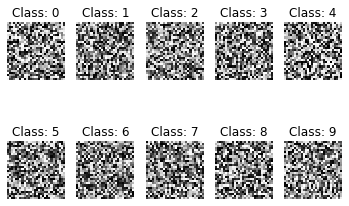

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


200 loss_D 0.66859746 loss_G 0.9750713


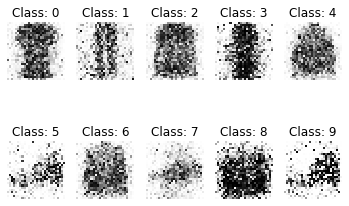

400 loss_D 0.6946429 loss_G 0.74402


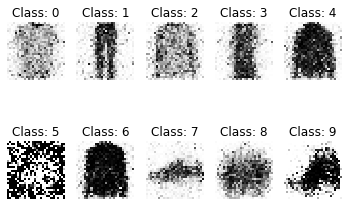

600 loss_D 0.7065479 loss_G 0.7102133


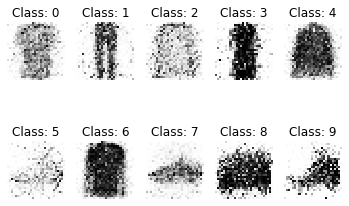

800 loss_D 0.7003616 loss_G 0.7072814


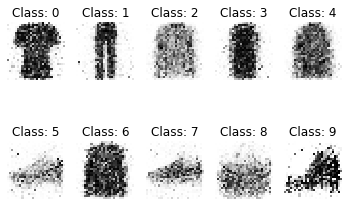

1000 loss_D 0.69947284 loss_G 0.71005493


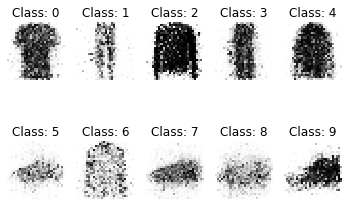

1200 loss_D 0.6968292 loss_G 0.70295


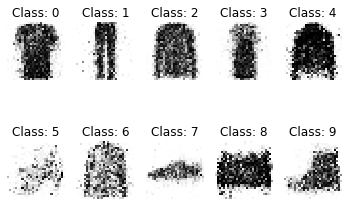

1400 loss_D 0.6958294 loss_G 0.70598286


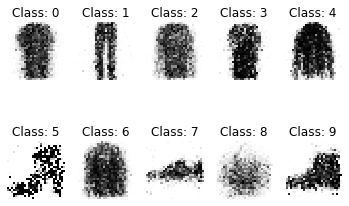

1600 loss_D 0.69674253 loss_G 0.7054268


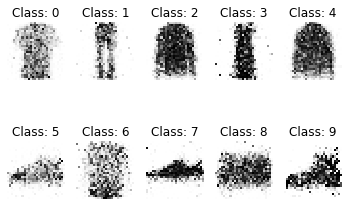

1800 loss_D 0.69740903 loss_G 0.7045463


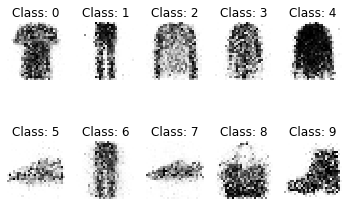

2000 loss_D 0.6912061 loss_G 0.70824885


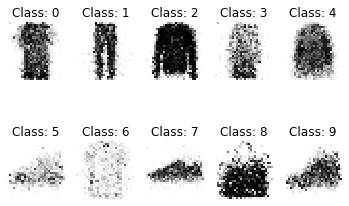

2200 loss_D 0.6978948 loss_G 0.7001983


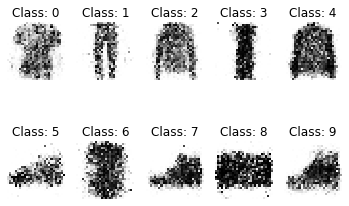

2400 loss_D 0.6952558 loss_G 0.7010596


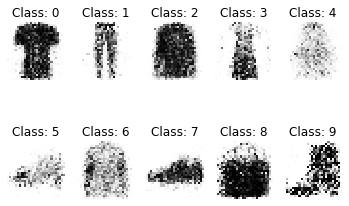

2600 loss_D 0.6936883 loss_G 0.7008074


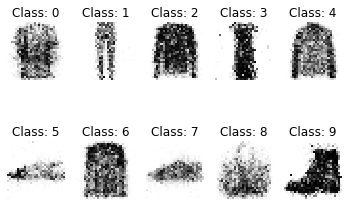

2800 loss_D 0.69217813 loss_G 0.7036573


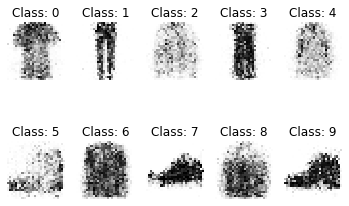

3000 loss_D 0.69389045 loss_G 0.69939274


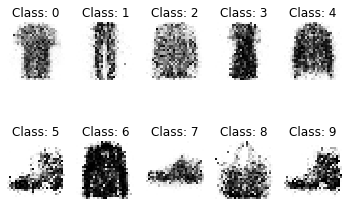

3200 loss_D 0.69327176 loss_G 0.70586526


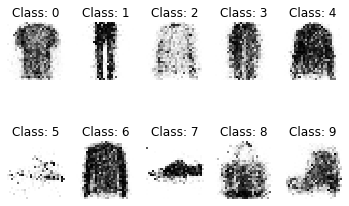

3400 loss_D 0.6937409 loss_G 0.6972538


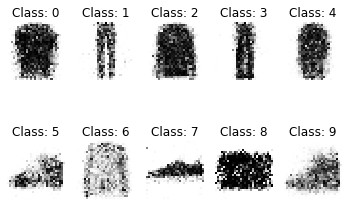

3600 loss_D 0.6897337 loss_G 0.69516075


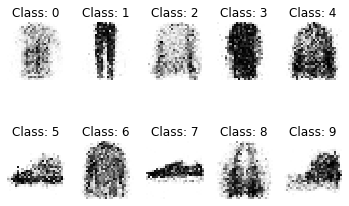

3800 loss_D 0.6932485 loss_G 0.70425045


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


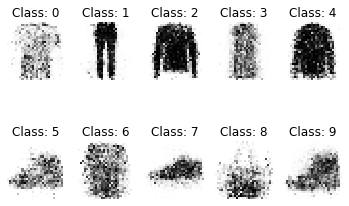

4000 loss_D 0.6922269 loss_G 0.7009264


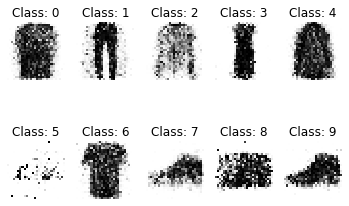

4200 loss_D 0.6939482 loss_G 0.7003898


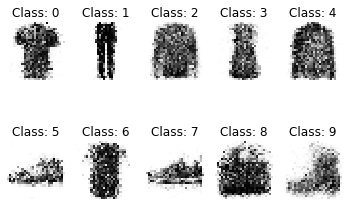

4400 loss_D 0.6969731 loss_G 0.70551586


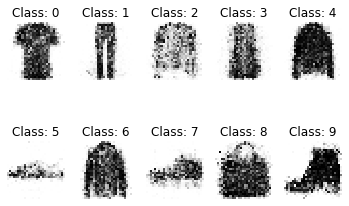

4600 loss_D 0.69248784 loss_G 0.6993353


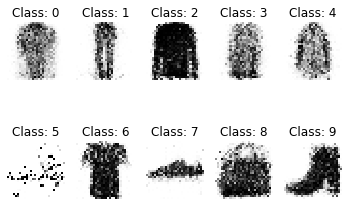

4800 loss_D 0.69426346 loss_G 0.7071372


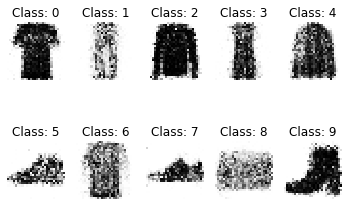

5000 loss_D 0.6929563 loss_G 0.6998459


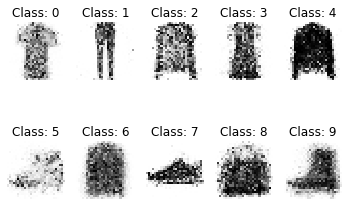

5200 loss_D 0.6949364 loss_G 0.70160663


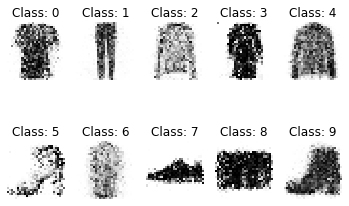

5400 loss_D 0.69474995 loss_G 0.7032065


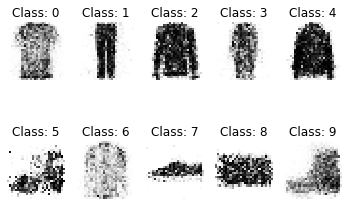

5600 loss_D 0.6957536 loss_G 0.6993023


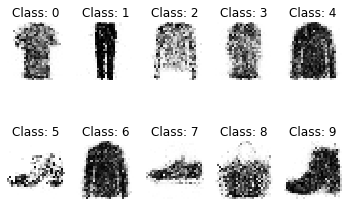

5800 loss_D 0.69367427 loss_G 0.6992072


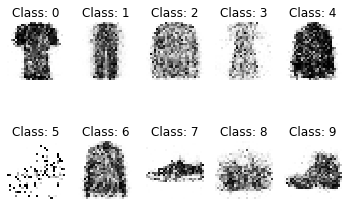

6000 loss_D 0.69414926 loss_G 0.7006202


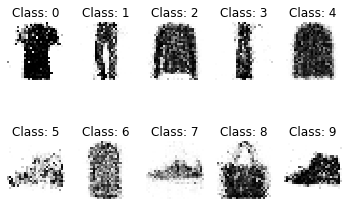

6200 loss_D 0.6907673 loss_G 0.71181786


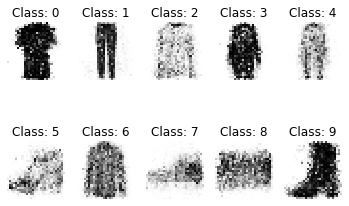

6400 loss_D 0.69282556 loss_G 0.7009573


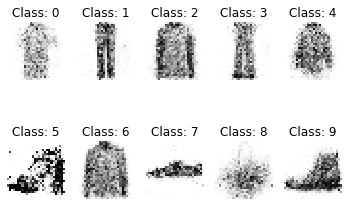

6600 loss_D 0.6933204 loss_G 0.6981316


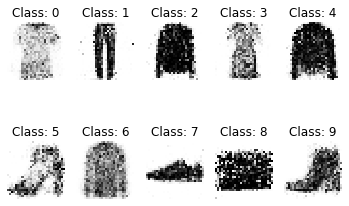

6800 loss_D 0.6928103 loss_G 0.70125926


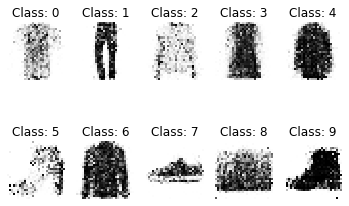

7000 loss_D 0.6939454 loss_G 0.69645417


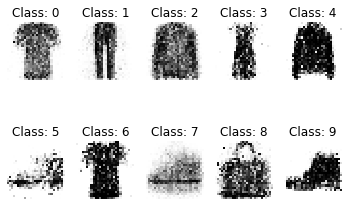

7200 loss_D 0.6943054 loss_G 0.7008684


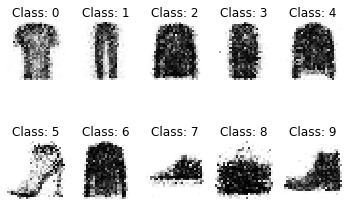

7400 loss_D 0.6924971 loss_G 0.6994391


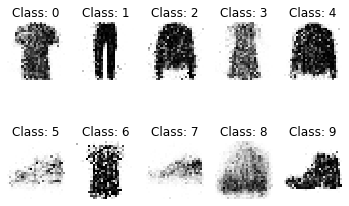

7600 loss_D 0.6942637 loss_G 0.69810754


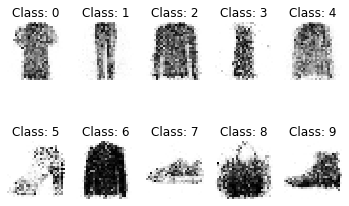

7800 loss_D 0.6929965 loss_G 0.6982467


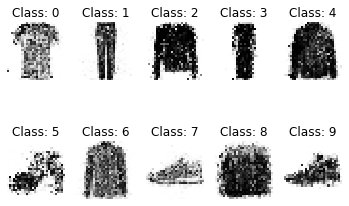

8000 loss_D 0.6938299 loss_G 0.6986691


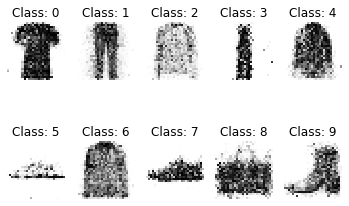

8200 loss_D 0.6932256 loss_G 0.6981524


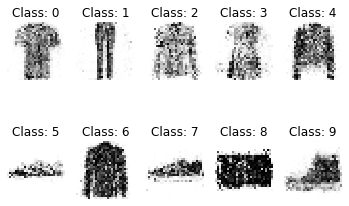

8400 loss_D 0.69360805 loss_G 0.697654


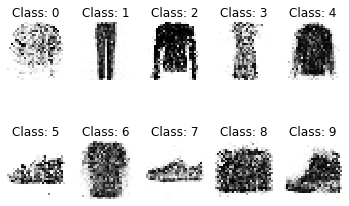

8600 loss_D 0.69402087 loss_G 0.7004076


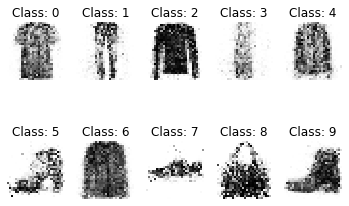

8800 loss_D 0.69333977 loss_G 0.69447124


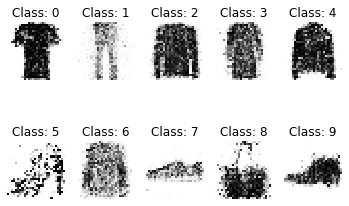

9000 loss_D 0.6927009 loss_G 0.70040274


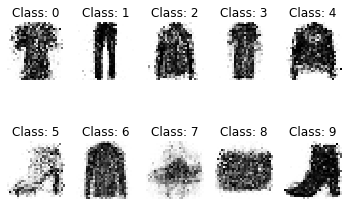

9200 loss_D 0.69274414 loss_G 0.6977578


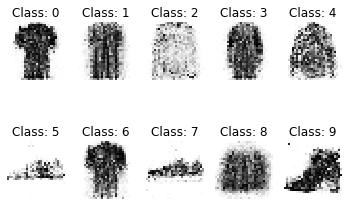

9400 loss_D 0.69185805 loss_G 0.7007125


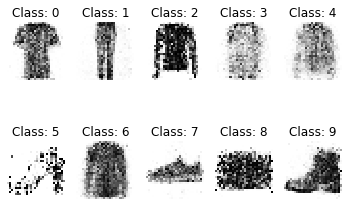

9600 loss_D 0.6941339 loss_G 0.70551014


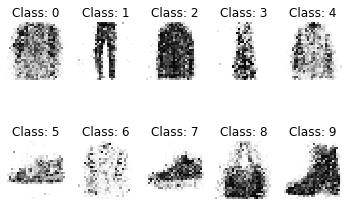

9800 loss_D 0.6926564 loss_G 0.698149


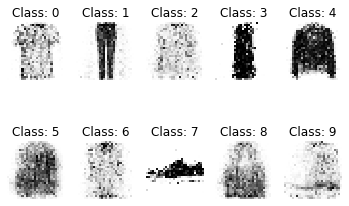

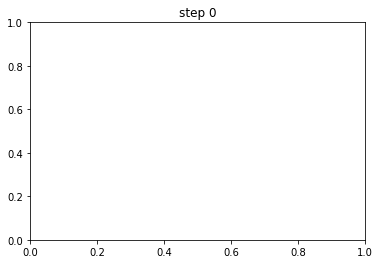

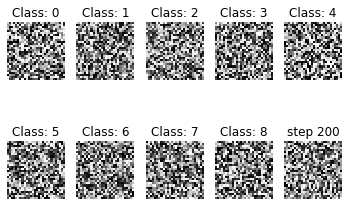

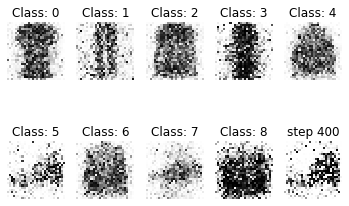

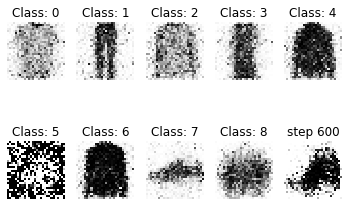

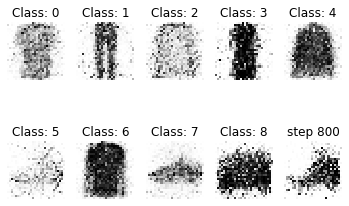

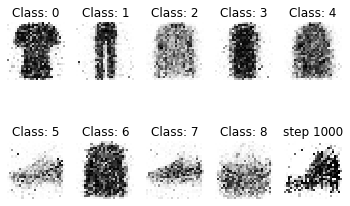

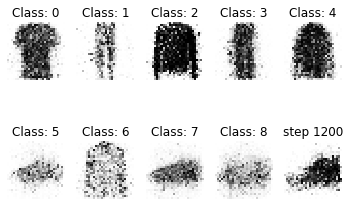

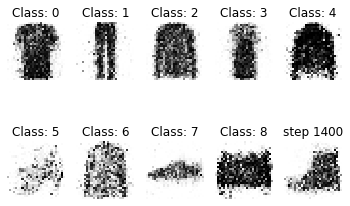

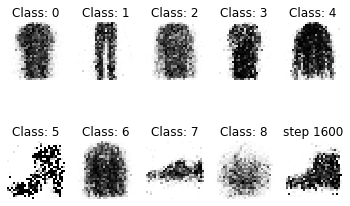

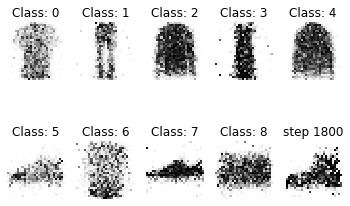

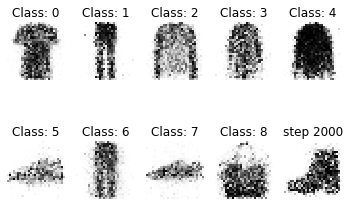

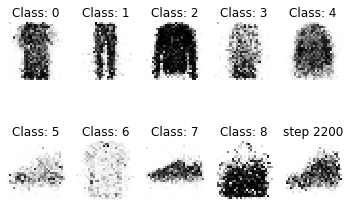

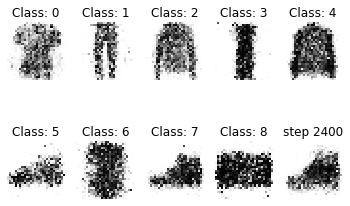

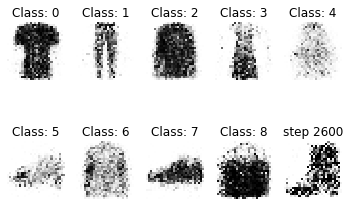

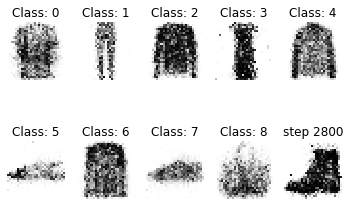

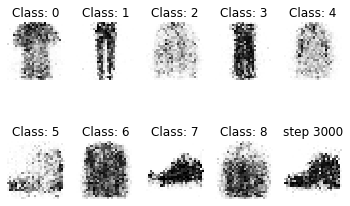

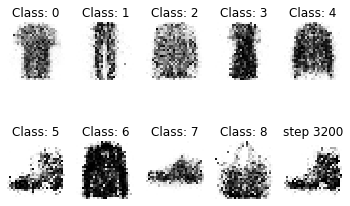

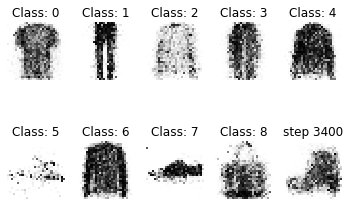

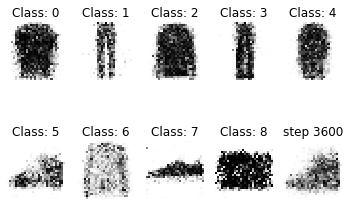

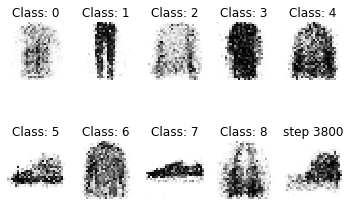

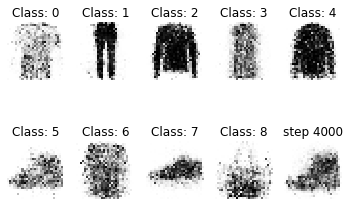

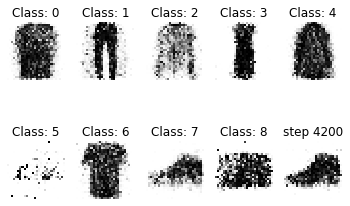

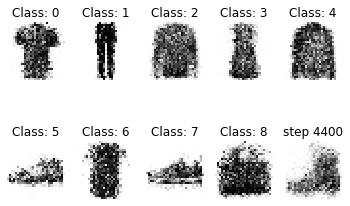

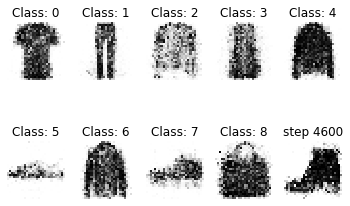

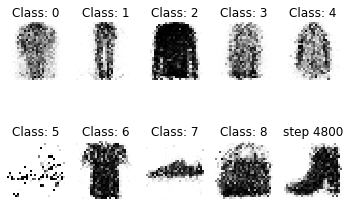

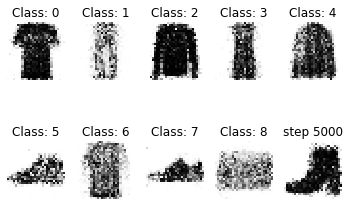

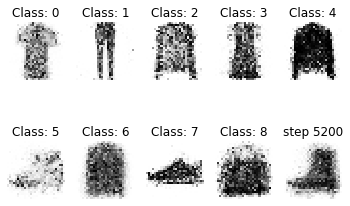

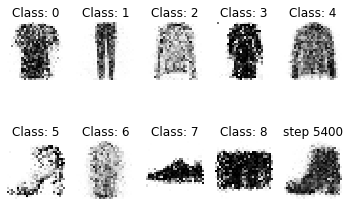

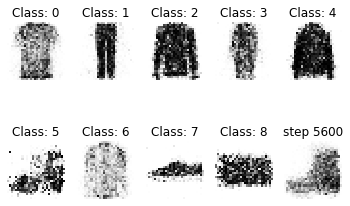

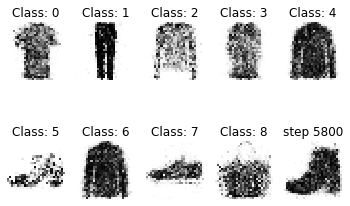

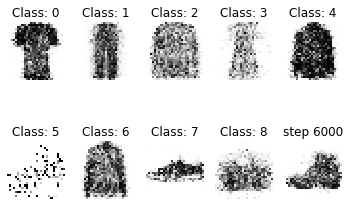

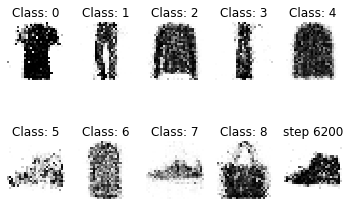

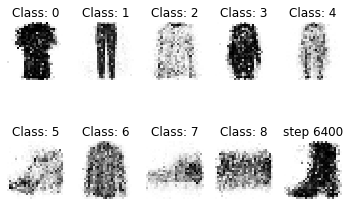

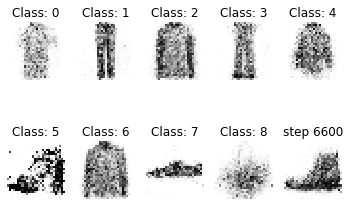

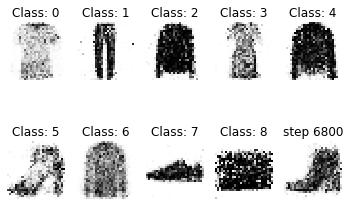

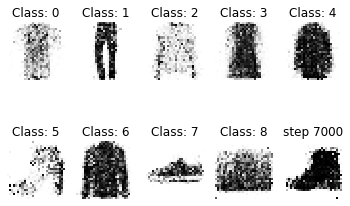

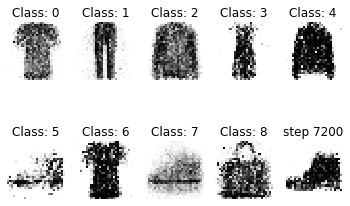

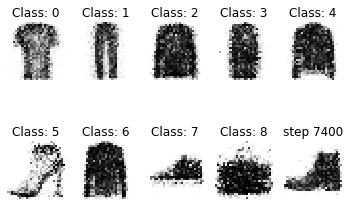

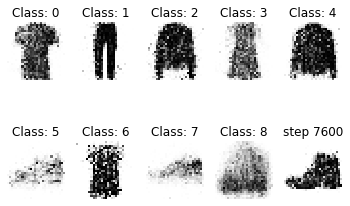

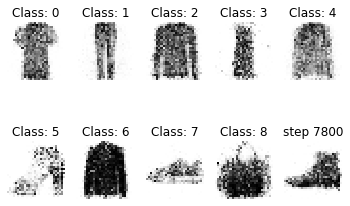

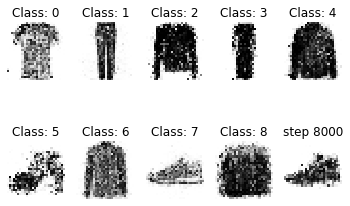

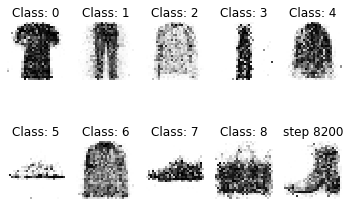

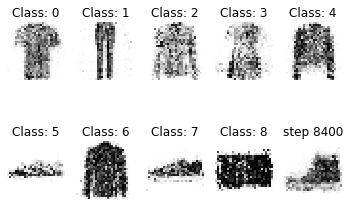

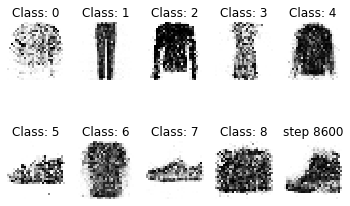

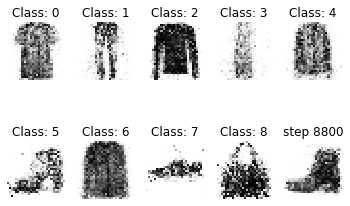

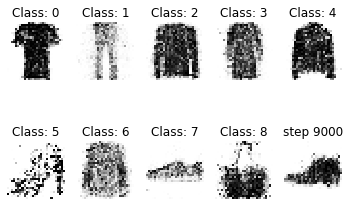

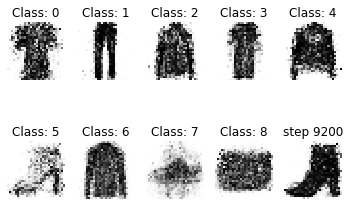

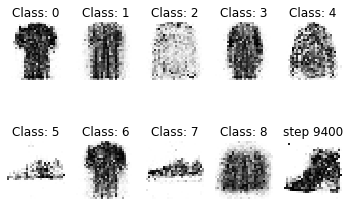

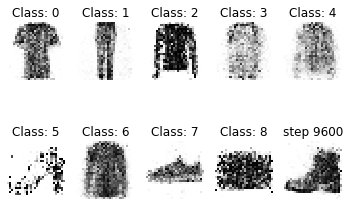

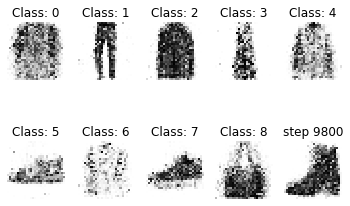

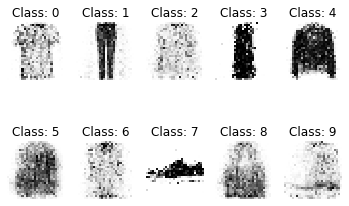

In [0]:
# G és D tanítása, kirajzolással

for step in range(10000):
    
  # képekből véletlen batch-nyi kiválasztása
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  # újdonság a CGAN-ban a GAN-hoz képest: a címkéket is használjuk
  imgs, labels = x_train[idx], y_train[idx]
  
  
  # egy batch-nyi kép generálás
  noise = np.random.normal(0, 1, (batch_size, cgan.latent_dim))
  
  # újdonság a CGAN-ban a GAN-hoz képest: a címkéket is használjuk
  gen_imgs = cgan.generator.predict([noise, labels])
  
  # diszkriminátor tanítása
  d_loss_real = cgan.discriminator.train_on_batch([imgs, labels], valid)
  d_loss_fake = cgan.discriminator.train_on_batch([gen_imgs, labels], fake)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
  
  
  # generátor tanítása

  # újdonság a CGAN-ban a GAN-hoz képest: a címke feltétellel tanítunk
  sampled_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
  g_loss = cgan.combined.train_on_batch([noise, sampled_labels], valid)
  
  # log
  if step % 200 == 0:
    print(step, 'loss_D', d_loss[0], 'loss_G', g_loss)
    
  # generált képek kirajzolása
  if step % 200 == 0:
    plot_images(cgan, step)

In [0]:
# lehetne tovább is futtatni a tanítást

# hosszabb tanítással kb ilyen minőségű képeket lehet generálni : 
# https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
# https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Example-of-100-Generated-items-of-Clothing-using-an-Conditional-GAN-1024x768.png